<a href="https://colab.research.google.com/github/Sakhmat/CS420_web/blob/main/CS420_Code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2025-12-04 10:42:11--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2025-12-04 10:42:11 (31.9 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [2]:
!pip install deepface
!unzip "archive.zip" -d DATASET

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/DATASET/train/5/train_00987_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_00990_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_00991_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_00992_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01002_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01010_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01011_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01013_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01015_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01017_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01039_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01048_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01049_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01053_aligned.jpg  
  inflating: DATASET/DATASET/train/5/train_01070_aligned.jpg  
  in

In [3]:
import cv2
import os
import pandas as pd
import numpy as np
from deepface import DeepFace
from tqdm import tqdm

# --- 1. CẤU HÌNH ĐƯỜNG DẪN (Đã sửa chuẩn cho Windows) ---

# Dùng r"..." để tránh lỗi đường dẫn trên Windows
BASE_DATA_DIR = r"/content/DATASET/DATASET"

# Lưu ý: Đã sửa dòng này trỏ đúng vào train_labels.csv
TRAIN_LABEL_PATH = r"/content/DATASET/train_labels.csv"
TEST_LABEL_PATH = r"/content/DATASET/test_labels.csv"
OUTPUT_DIR = "RAF_DB_Clean/"
DETECTOR_BACKEND = 'retinaface'

LABEL_MAP = {
    1: "surprise", 2: "fear", 3: "disgust", 4: "happy",
    5: "sad", 6: "anger", 7: "neutral"
}

# --- 2. HÀM QUÉT FILE (MỚI & MẠNH MẼ HƠN) ---
def scan_all_images(base_dir):
    """
    Thay vì đoán đường dẫn, hàm này đi quét một lượt toàn bộ folder
    để tạo ra 'bản đồ' vị trí chính xác của từng ảnh.
    """
    print(f"-> Đang quét toàn bộ file trong: {base_dir} ...")
    image_map = {}
    count = 0
    # os.walk sẽ đi xuyên qua tất cả thư mục con
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                # Key: tên file, Value: đường dẫn đầy đủ
                image_map[file] = os.path.join(root, file)
                count += 1

    print(f"-> Đã tìm thấy {count} ảnh trong hệ thống.")
    return image_map

# --- 3. HÀM XỬ LÝ CHÍNH ---

def process_raf_db():
    print("--- BẮT ĐẦU XỬ LÝ (PHIÊN BẢN QUÉT MAP) ---")

    # 1. Kiểm tra đường dẫn đầu vào
    if not os.path.exists(BASE_DATA_DIR):
        print(f"LỖI: Không tìm thấy thư mục ảnh: {BASE_DATA_DIR}")
        return
    if not os.path.exists(TRAIN_LABEL_PATH):
        print(f"LỖI: Không thấy file CSV: {TRAIN_LABEL_PATH}")
        return

    # 2. Tạo bản đồ ảnh (Bước quan trọng nhất)
    full_image_map = scan_all_images(BASE_DATA_DIR)

    # 3. Đọc và gộp CSV
    print("-> Đang đọc file CSV...")
    df_train = pd.read_csv(TRAIN_LABEL_PATH)
    df_test = pd.read_csv(TEST_LABEL_PATH)

    df_train['dataset_split'] = 'train'
    df_test['dataset_split'] = 'test'

    full_df = pd.concat([df_train, df_test], ignore_index=True)
    full_df.columns = ['image', 'label', 'dataset_split']

    print(f"-> Tổng số dòng CSV cần xử lý: {len(full_df)}")

    # 4. Tạo thư mục đầu ra
    for split in ['train', 'test']:
        for label_name in LABEL_MAP.values():
            os.makedirs(os.path.join(OUTPUT_DIR, split, label_name), exist_ok=True)

    success_count = 0
    fail_count = 0

    # 5. Chạy vòng lặp xử lý
    print("-> Bắt đầu cắt mặt...")
    for index, row in tqdm(full_df.iterrows(), total=full_df.shape[0]):
        csv_img_name = row['image'] # Tên trong CSV (thường có _aligned)
        label_val = row['label']
        split_type = row['dataset_split']

        # Xử lý tên nhãn
        if isinstance(label_val, int) or str(label_val).isdigit():
            label_name = LABEL_MAP.get(int(label_val))
        else:
            label_name = str(label_val).lower().strip()

        if not label_name: continue

        # --- LOGIC TÌM ẢNH TỪ BẢN ĐỒ ---
        real_path = None

        # Cách 1: Tìm đúng tên như trong CSV (ví dụ train_00001_aligned.jpg)
        if csv_img_name in full_image_map:
            real_path = full_image_map[csv_img_name]

        # Cách 2: Nếu không thấy, thử bỏ đuôi _aligned (ví dụ train_00001.jpg)
        if real_path is None:
            clean_name_search = csv_img_name.replace("_aligned", "")
            if clean_name_search in full_image_map:
                real_path = full_image_map[clean_name_search]

        # Nếu vẫn không thấy -> Bỏ tay
        if real_path is None:
            # print(f"Không tìm thấy ảnh: {csv_img_name}") # Bật lên nếu muốn debug
            fail_count += 1
            continue

        # Đường dẫn lưu kết quả (Luôn xóa _aligned cho tên file sạch đẹp)
        final_name = csv_img_name.replace("_aligned", "")
        output_path = os.path.join(OUTPUT_DIR, split_type, label_name, final_name)

        # Nếu ảnh đã tồn tại rồi thì bỏ qua cho nhanh
        if os.path.exists(output_path):
            continue

        try:
            # Dùng DeepFace extract
            face_info = DeepFace.extract_faces(
                img_path=real_path,
                detector_backend=DETECTOR_BACKEND,
                enforce_detection=True,
                align=True
            )
            # Convert sang BGR để lưu bằng OpenCV
            face_img = cv2.cvtColor(face_info[0]['face'] * 255, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, face_img)
            success_count += 1

        except:
            # Fallback: Nếu Deepface lỗi (không thấy mặt), lấy ảnh gốc resize
            try:
                img_raw = cv2.imread(real_path)
                if img_raw is not None:
                    img_resized = cv2.resize(img_raw, (224, 224))
                    cv2.imwrite(output_path, img_resized)
                    success_count += 1
                else:
                    fail_count += 1
            except:
                fail_count += 1

    print(f"\n--- HOÀN TẤT! ---")
    print(f"Thành công: {success_count}")
    print(f"Thất bại (File lỗi/Không tìm thấy): {fail_count}")
    print(f"Folder sạch đã tạo tại: {os.path.abspath(OUTPUT_DIR)}")

if __name__ == "__main__":
    process_raf_db()

25-12-04 10:42:47 - Directory /root/.deepface has been created
25-12-04 10:42:47 - Directory /root/.deepface/weights has been created
--- BẮT ĐẦU XỬ LÝ (PHIÊN BẢN QUÉT MAP) ---
-> Đang quét toàn bộ file trong: /content/DATASET/DATASET ...
-> Đã tìm thấy 15339 ảnh trong hệ thống.
-> Đang đọc file CSV...
-> Tổng số dòng CSV cần xử lý: 15339
-> Bắt đầu cắt mặt...


  0%|          | 0/15339 [00:00<?, ?it/s]

25-12-04 10:42:50 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
 26%|██▌       | 30.4M/119M [00:00<00:00, 301MB/s]
 63%|██████▎   | 75.0M/119M [00:00<00:00, 385MB/s]
100%|██████████| 119M/119M [00:00<00:00, 355MB/s]
100%|██████████| 15339/15339 [30:50<00:00,  8.29it/s]


--- HOÀN TẤT! ---
Thành công: 15339
Thất bại (File lỗi/Không tìm thấy): 0
Folder sạch đã tạo tại: /content/RAF_DB_Clean


--- Đang xây dựng kiến trúc mô hình... ---
94765736/94765736 [==============================] - 1s 0us/step
Đã tải ResNet50. Số lớp: 175. Đã đóng băng.
--- Xây dựng mô hình hoàn tất. ---

--- CẤU TRÚC MÔ HÌNH (MODEL SUMMARY) ---
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                             

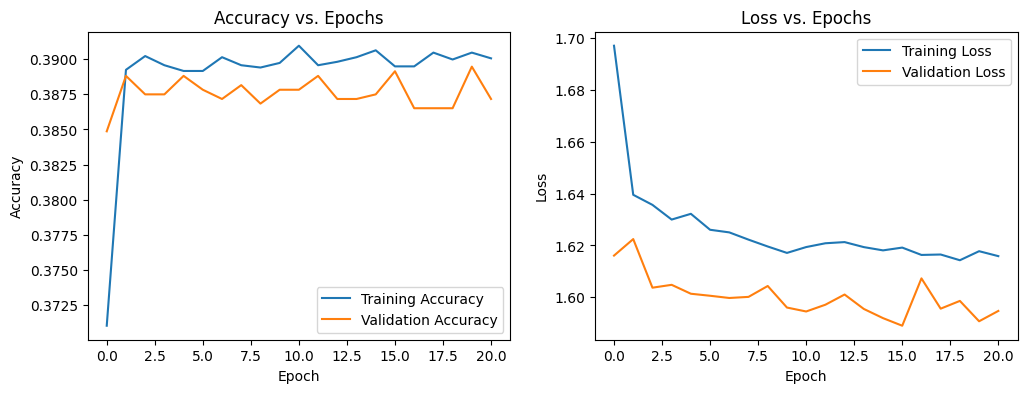

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os

# --- 1. CÁC THAM SỐ CẤU HÌNH (TỪ BƯỚC 3) ---

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3) # 3 là 3 kênh màu (RGB)
NUM_CLASSES = 7 # Số lớp cảm xúc (RAF-DB có 7 cảm xúc)

# --- 2. HÀM XÂY DỰNG MÔ HÌNH (TỪ BƯỚC 3) ---

def build_model(num_classes):
    print("--- Đang xây dựng kiến trúc mô hình... ---")
    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_shape=IMG_SHAPE)
    base_model.trainable = False
    print(f"Đã tải ResNet50. Số lớp: {len(base_model.layers)}. Đã đóng băng.")

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    print("--- Xây dựng mô hình hoàn tất. ---")
    return model

# --- 3. BIÊN DỊCH (COMPILE) MÔ HÌNH (TỪ BƯỚC 3) ---

model = build_model(num_classes=NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("\n--- CẤU TRÚC MÔ HÌNH (MODEL SUMMARY) ---")
model.summary()

# --- 4. CHUẨN BỊ BỘ TẢI DỮ LIỆU (DATA GENERATORS) ---

print("\n--- Đang chuẩn bị Bộ tải dữ liệu (Data Generators)... ---")

# === LỖI ĐƯỢC SỬA Ở ĐÂY ===
# 1. Dùng 'r' để sửa lỗi dấu '\'
# 2. Đảo ngược 'train' và 'test' về đúng logic
TRAIN_DIR = r"/content/RAF_DB_Clean/train" # <-- Sửa logic
TEST_DIR = r"/content/RAF_DB_Clean/test"  # <-- Sửa logic
# =========================

BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# --- 5. ĐỊNH NGHĨA CALLBACKS ---

print("--- Đang định nghĩa Callbacks... ---")

checkpoint = ModelCheckpoint(
    'best_emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [checkpoint, early_stop]

# --- 6. BẮT ĐẦU HUẤN LUYỆN (TRAINING) 🚀 ---

print("--- BẮT ĐẦU HUẤN LUYỆN ---")
print("Việc này sẽ mất RẤT LÂU... Hãy kiên nhẫn.")

EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

print("--- HUẤN LUYỆN HOÀN TẤT ---")

# --- 7. LƯU VÀ VẼ BIỂU ĐỒ KẾT QUẢ 📊 ---

model.save("final_emotion_model.h5")
print("Đã lưu mô hình cuối cùng vào 'final_emotion_model.h5'")

print("--- Đang vẽ biểu đồ lịch sử huấn luyện... ---")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('training_history.png')
print("Đã lưu biểu đồ vào 'training_history.png'")

Found 3068 images belonging to 7 classes.
Các lớp cảm xúc: ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
✅ Đã tải mô hình 'best_emotion_model.h5' thành công.

--- Bắt đầu đánh giá mô hình trên tập kiểm thử ---
96/96 [==============================] - 12s 112ms/step

              BÁO CÁO PHÂN LOẠI CHI TIẾT                
              precision    recall  f1-score      support
anger          0.500000  0.024691  0.047059   162.000000
disgust        0.000000  0.000000  0.000000   160.000000
fear           0.000000  0.000000  0.000000    74.000000
happy          0.387255  1.000000  0.558304  1185.000000
neutral        0.000000  0.000000  0.000000   680.000000
sad            0.000000  0.000000  0.000000   478.000000
surprise       0.000000  0.000000  0.000000   329.000000
accuracy       0.387549  0.387549  0.387549     0.387549
macro avg      0.126751  0.146384  0.086480  3068.000000
weighted avg   0.175977  0.387549  0.218127  3068.000000

                 MA TRẬN N

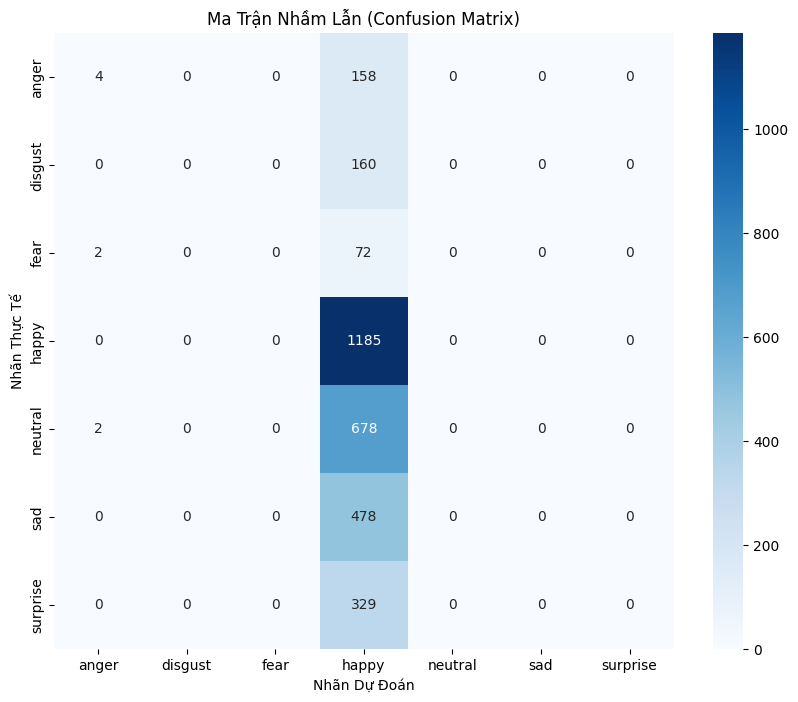

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- CẤU HÌNH (Phải giống hệt file train.py) ---
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Sử dụng đường dẫn TEST_DIR đã sửa lỗi
TEST_DIR = r"/content/RAF_DB_Clean/test" # <-- Sửa lại đường dẫn test của bạn!

# --- 1. CHUẨN BỊ DATA GENERATOR CHO TEST ---

# CHỈ rescale, KHÔNG tăng cường dữ liệu khi đánh giá
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Quan trọng: Giữ nguyên thứ tự để so sánh với nhãn
)

# Lấy danh sách các nhãn (tên thư mục)
class_labels = list(test_generator.class_indices.keys())
print(f"Các lớp cảm xúc: {class_labels}")

# --- 2. TẢI MÔ HÌNH TỐT NHẤT ---

try:
    # Tải mô hình đã được lưu ở Bước 4
    model = load_model('best_emotion_model.h5')
    print("✅ Đã tải mô hình 'best_emotion_model.h5' thành công.")
except Exception as e:
    print(f"❌ Lỗi tải mô hình: {e}")
    print("Vui lòng kiểm tra file 'best_emotion_model.h5' có tồn tại không.")
    exit()

# --- 3. ĐÁNH GIÁ SÂU ---

print("\n--- Bắt đầu đánh giá mô hình trên tập kiểm thử ---")

# a) Dự đoán tất cả các ảnh trong tập kiểm thử
test_steps = test_generator.samples // BATCH_SIZE
predictions = model.predict(test_generator, steps=test_steps + 1)

# b) Lấy nhãn dự đoán (predicted labels) và nhãn thực tế (true labels)
# Lấy index của xác suất cao nhất
predicted_classes = np.argmax(predictions, axis=1)
# Lấy nhãn thực tế từ generator
true_classes = test_generator.classes[:len(predicted_classes)]

# c) Tính Ma trận Nhầm lẫn (Confusion Matrix)
cm = confusion_matrix(true_classes, predicted_classes)

# d) Tính Báo cáo Phân loại (Classification Report)
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# --- 4. HIỂN THỊ KẾT QUẢ ---

print("\n========================================================")
print("              BÁO CÁO PHÂN LOẠI CHI TIẾT                ")
print("========================================================")
df_report = pd.DataFrame(report).transpose()
print(df_report)


print("\n========================================================")
print("                 MA TRẬN NHẦM LẪN (HEATMAP)              ")
print("========================================================")

# Vẽ Ma trận Nhầm lẫn dưới dạng Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True, # Hiển thị số lượng
            fmt='d',    # Format số nguyên
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Ma Trận Nhầm Lẫn (Confusion Matrix)')
plt.xlabel('Nhãn Dự Đoán')
plt.ylabel('Nhãn Thực Tế')
plt.savefig('confusion_matrix.png')
print("Đã lưu Ma trận Nhầm lẫn vào 'confusion_matrix.png'")
# plt.show() # Uncomment nếu bạn muốn xem ngay lập tức

In [6]:
import cv2
from deepface import DeepFace
import numpy as np
from tensorflow.keras.models import load_model

# --- CẤU HÌNH ---
MODEL_PATH = 'best_emotion_model.h5'
IMG_WIDTH = 224 # Kích thước mô hình yêu cầu

# Ánh xạ nhãn (Phải khớp với thứ tự thư mục trong tập train)
# Bạn hãy kiểm tra lại file evaluate.py hoặc log train để có thứ tự chính xác
EMOTION_LABELS = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# LƯU Ý: Thứ tự này phải khớp với train_generator.class_indices.keys()

# --- 1. TẢI MÔ HÌNH ---
try:
    model = load_model(MODEL_PATH)
    print(f"✅ Đã tải mô hình {MODEL_PATH}")
except:
    print(f"❌ KHÔNG tìm thấy mô hình {MODEL_PATH}. Vui lòng chạy Bước 4 trước.")
    exit()


def predict_emotion_from_image(image_path):
    print(f"\n--- Bắt đầu xử lý ảnh: {image_path} ---")

    # 2. Phát hiện và căn chỉnh khuôn mặt bằng DeepFace
    try:
        # Tương tự như preprocess.py, dùng RetinaFace để phát hiện và căn chỉnh
        face_info = DeepFace.extract_faces(
            img_path=image_path,
            detector_backend='retinaface',
            enforce_detection=True,
            align=True
        )
    except Exception as e:
        print(f"❌ Lỗi DeepFace: Không tìm thấy khuôn mặt trong ảnh hoặc lỗi khác. ({e})")
        return

    # Lấy khuôn mặt đã căn chỉnh (luôn là mặt đầu tiên [0])
    face_img_array_rgb = face_info[0]['face']

    # 3. Tiền xử lý dữ liệu cho mô hình CNN
    # a) Resize về kích thước mô hình yêu cầu (224x224)
    face_resized = cv2.resize(face_img_array_rgb, (IMG_WIDTH, IMG_HEIGHT))

    # b) Chuẩn hóa pixel về [0, 1] (DeepFace đã làm việc này, nhưng ta kiểm tra)
    face_normalized = face_resized / 255.0

    # c) Thêm một chiều Batch (mô hình CNN luôn yêu cầu [1, H, W, C])
    input_data = np.expand_dims(face_normalized, axis=0)

    # 4. Dự đoán
    predictions = model.predict(input_data)[0] # [0] để lấy vector xác suất

    # Lấy nhãn và xác suất cao nhất
    max_index = np.argmax(predictions)
    predicted_emotion = EMOTION_LABELS[max_index]
    confidence = predictions[max_index] * 100

    print("\n--- KẾT QUẢ DỰ ĐOÁN ---")
    print(f"🥇 Cảm xúc được dự đoán: {predicted_emotion.upper()}")
    print(f"   Độ tự tin (Confidence): {confidence:.2f}%")

    # Hiển thị tất cả xác suất (Tùy chọn)
    print("--- Phân bố xác suất: ---")
    for label, prob in zip(EMOTION_LABELS, predictions):
        print(f"  - {label}: {prob*100:.2f}%")


# --- CHẠY CHƯƠNG TRÌNH ---
if __name__ == "__main__":
    # Thay thế bằng đường dẫn ảnh BẤT KỲ của bạn
    # Ví dụ: ảnh bạn tự chụp có khuôn mặt
    test_image_path = '/content/IMG_E4820.JPG'

    # Tên file ảnh ví dụ (BẠN PHẢI TỰ TÌM HOẶC CHỤP)

    predict_emotion_from_image(test_image_path)

✅ Đã tải mô hình best_emotion_model.h5

--- Bắt đầu xử lý ảnh: /content/IMG_E4820.JPG ---
1/1 [==============================] - 1s 1s/step

--- KẾT QUẢ DỰ ĐOÁN ---
🥇 Cảm xúc được dự đoán: HAPPY
   Độ tự tin (Confidence): 45.56%
--- Phân bố xác suất: ---
  - anger: 2.83%
  - disgust: 6.10%
  - fear: 0.97%
  - happy: 45.56%
  - neutral: 21.64%
  - sad: 13.49%
  - surprise: 9.41%


In [7]:
import cv2
import numpy as np
from flask import Flask, request, jsonify
from google.colab.patches import cv2_imshow # Để debug nếu cần

# 1. Khởi tạo App và Model
app = Flask(__name__)
# Đảm bảo model đã được load ở các cell trước đó: global model

# 2. Load bộ nhận diện khuôn mặt (chắc chắn file xml đã có)
# Nếu bạn đã chạy lệnh !wget ở trên thì dùng dòng này:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# Nếu chưa thì dùng dòng mặc định (thường vẫn ổn trên Colab):
if face_cascade.empty():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 3. Warm-up Model (Tránh lỗi đơ lần đầu)
try:
    print("Đang warm-up model...")
    model.predict(np.zeros((1, 224, 224, 3))) # Thay 224 bằng kích thước input model của bạn
    print("Warm-up xong.")
except Exception as e:
    print(f"Cảnh báo warm-up: {e}")

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'Chưa chọn file'}), 400

    file = request.files['file']
    try:
        # Đọc ảnh
        file_bytes = np.frombuffer(file.read(), np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

        # Cắt mặt (Bước mới thêm)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        if len(faces) > 0:
            # Lấy mặt to nhất
            (x, y, w, h) = max(faces, key=lambda f: f[2] * f[3])
            # Có thể mở rộng vùng cắt một chút (padding) để lấy hết cằm/trán nếu cần
            padding = 10
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(img.shape[1] - x, w + 2*padding)
            h = min(img.shape[0] - y, h + 2*padding)

            face_img = img[y:y+h, x:x+w]
        else:
            # Fallback: Nếu không tìm thấy mặt thì dùng ảnh gốc (hoặc trả lỗi tùy bạn)
            # Ở đây tôi để dùng ảnh gốc để tránh crash, nhưng độ chính xác sẽ thấp
            print("Cảnh báo: Không tìm thấy mặt, dùng ảnh gốc.")
            face_img = img

        # Tiền xử lý & Dự đoán
        face_img = cv2.resize(face_img, (224, 224)) # Đảm bảo đúng size model train
        face_img = face_img / 255.0
        face_img = np.expand_dims(face_img, axis=0)

        prediction = model.predict(face_img)
        # ... (Phần xử lý kết quả giữ nguyên)
        predicted_class_idx = np.argmax(prediction)
        predicted_label = CLASS_NAMES[predicted_class_idx]
        confidence = float(np.max(prediction)) * 100

        return jsonify({
            'label': predicted_label,
            'confidence': f"{confidence:.2f}%",
            'probabilities': prediction[0].tolist()
        })

    except Exception as e:
        return jsonify({'error': str(e)}), 500

# Chạy app (trên Colab thường dùng run_with_ngrok hoặc port forwarding)
if __name__ == '__main__':
    app.run()

Đang warm-up model...
1/1 [==============================] - 0s 21ms/step
Warm-up xong.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
